## MNIST IMAGES
## Name: Anas Kouri

#Import some useful libraries

In [ ]:
import pandas as pd
import numpy as np

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Importing Data

In [ ]:
# Functions to load MNIST images and unpack into train and test set.
# - loadData reads a image and formats it into a 28x28 long array
# - loadLabels reads the corresponding label data, one for each image
# - load packs the downloaded image and label data into a combined format to be read later by
#   the CNTK text reader

def loadData(src, cimg):
    print ('Downloading ' + src)
    gzfname, h = urlretrieve(src, './delete.me')
    print ('Done.')
    try:
        with gzip.open(gzfname) as gz:
            n = struct.unpack('I', gz.read(4))
            # Read magic number.
            if n[0] != 0x3080000:
                raise Exception('Invalid file: unexpected magic number.')
            # Read number of entries.
            n = struct.unpack('>I', gz.read(4))[0]
            if n != cimg:
                raise Exception('Invalid file: expected {0} entries.'.format(cimg))
            crow = struct.unpack('>I', gz.read(4))[0]
            ccol = struct.unpack('>I', gz.read(4))[0]
            if crow != 28 or ccol != 28:
                raise Exception('Invalid file: expected 28 rows/cols per image.')
            # Read data.
            res = np.fromstring(gz.read(cimg * crow * ccol), dtype = np.uint8)
    finally:
        os.remove(gzfname)
    return res.reshape((cimg, crow * ccol))

def loadLabels(src, cimg):
    print ('Downloading ' + src)
    gzfname, h = urlretrieve(src, './delete.me')
    print ('Done.')
    try:
        with gzip.open(gzfname) as gz:
            n = struct.unpack('I', gz.read(4))
            # Read magic number.
            if n[0] != 0x1080000:
                raise Exception('Invalid file: unexpected magic number.')
            # Read number of entries.
            n = struct.unpack('>I', gz.read(4))
            if n[0] != cimg:
                raise Exception('Invalid file: expected {0} rows.'.format(cimg))
            # Read labels.
            res = np.fromstring(gz.read(cimg), dtype = np.uint8)
    finally:
        os.remove(gzfname)
    return res.reshape((cimg, 1))

def try_download(dataSrc, labelsSrc, cimg):
    data = loadData(dataSrc, cimg)
    labels = loadLabels(labelsSrc, cimg)
    return np.hstack((data, labels))


In [ ]:
import gzip
import os
from urllib.request import urlretrieve
import struct
# URLs for the train image and label data
url_train_image = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'
url_train_labels = 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz'
num_train_samples = 60000

print("Downloading train data")
train = try_download(url_train_image, url_train_labels, num_train_samples)

# URLs for the test image and label data
url_test_image = 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz'
url_test_labels = 'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'
num_test_samples = 10000

print("Downloading test data")
test = try_download(url_test_image, url_test_labels, num_test_samples)

Done.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Done.
Done.
Done.


After downlading the data, we should split the train set into data and labels, and also for test set.

In [ ]:
X_train = train[:, :-1]
y_train = train[:, -1]
X_test = test[:, :-1]
y_test = test[:, -1]

In [ ]:
X_train.shape

(60000, 784)

In [ ]:
y_train.shape

(60000,)

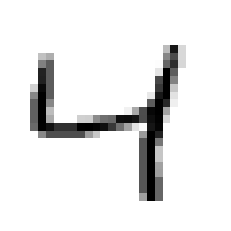

In [ ]:
# we show an example of images 
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X_train[2]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
plt.show()

This image looks like a 4. Let's see what the label tell us.

In [ ]:
y_train[2]

4

Indeed, the label is a 4.

# Multiclass Classification

Whereas binary classifiers distinguish between two classes, multiclass classifers can distinguish between more than two classes.

There are two diffrent ways to create a system that can classifie the digits into 10 classes from 0 to 9.

The first strategy is called the one-versus-the-rest(OvR). Basically, the goal is the train 10 binary classifier, one for each number (0-class, 1-class, 2-class..etc). Moreover, when we want to classify an image, we get the decision score from each classifier, and we choose the class whose classifier get us the highest score. 

The second strategy is to train a binary classifer for every pair of digits. for example, a classifier to distinguish between 0 and 1, another to distinguish between 0 and 2 or 0 and 3 ...etc. This strategy is called the One-versus-one(OvO). We have 10 classes, thus, we need to train 10*(10-1)/2 = 45 classifiers. 


# Support Vector Machine (SVM)

Let's first try a strictly binary classifier such a SVM. The classifier will automatically runs OvR or OvO, depending on the algorithm.

In [ ]:
from sklearn.svm import SVC
svm_classifier = SVC(gamma="auto", random_state=42)
svm_classifier.fit(X_train[:1000],y_train[:1000])
svm_classifier.predict([some_digit])

array([4], dtype=uint8)

The classifier predicted indeed the right class 4.

Scikit-Learn actually useed the OvO strategy, so it trains 45 binary classifiers. Then, the library got their decision score, and selected the class that has a high score.

In [ ]:
scores = svm_classifier.decision_function([some_digit])
scores

array([[ 3.82111996,  7.09167958,  4.83444983,  1.79943469,  9.29932174,
         0.79485736,  2.80437474,  8.10392157, -0.22417259,  5.84182891]])

In [ ]:
svm_classifier.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
np.argmax(scores)

4

we can see indeed, that the highest score is the one corresponding to class 4.

We can also force scikit-learn to use OvR insted of OvO. To do that, we should import OneVsRestClassifier class.


In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_svm_classifier = OneVsRestClassifier(SVC(gamma="auto",random_state=42))
ovr_svm_classifier.fit(X_train[:1000],y_train[:1000])
ovr_svm_classifier.predict(([some_digit]))

array([4], dtype=uint8)

# Stochastic Gradient Descent(SGD)

Let's to train a SGD Classifier, which is a classifer that can handle multiple classes natively

In [ ]:
from sklearn.linear_model import SGDClassifier
sgd_classifier = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_classifier.fit(X_train,y_train)


SGDClassifier(random_state=42)

In [ ]:
sgd_classifier.predict([some_digit])

array([4], dtype=uint8)

In [ ]:
sgd_classifier.decision_function([some_digit])

array([[-34143.40703505, -21942.13780869,  -4018.29275037,
         -2239.19313075,     43.09419826, -15058.88052383,
        -33653.31059893,  -8277.80610963,  -7460.52016321,
        -14180.15338984]])

We can see that the highest score is the one corresponding to class 4. Therefore, we can evaluate this classifier model. We can use cross-validation. This method will help us to evaluate the model without actually apply it on the test set. There is a function called cross_val_score() that can evaluate the classifier's accuracy.

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_classifier,X_train,y_train,cv=3,scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

The SGDClassifier gets over 85% on all test folds. We can improve it a little bit by Scalling the inuputs.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_classifier,X_train_scaled,y_train,cv=3,scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

After scaling the inputs we get more than 89% accuracy.

# Error Analysis

First lets calculate the confusion matrix for the SGDClassifier.


In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_predict = cross_val_predict(sgd_classifier,X_train_scaled,y_train,cv=3)
confu_mx = confusion_matrix(y_train,y_train_predict)
confu_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

Seeing alot of numbers like that is a little bit hard to understand. it's better to look at and image representation of the confusion matrix using Matlplotlib's matshow() function. 

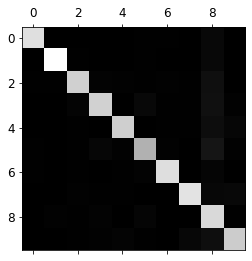

In [ ]:
plt.matshow(confu_mx,cmap=plt.cm.gray)

This plot looks good, since most images are on the diagonal. The 5 class looks a little bit darke, which means that the classifier did not work good on some of 5 images. 

Finally, lets try another classifier which is the KNN classifier.

# KNN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier(weights='distance',n_neighbors =4)
knn_classifier.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [ ]:
y_knn_predicted = knn_classifier.predict(X_test)

Let's mesure the accuracy score 

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_knn_predicted)

0.9714

Oh, wonderful, we got a very good classifier with 97% accuracy. 
